**Goal**: Build an AI agent that visualizes the carbon footprint in 2 by 2 quadrant based on the person's lifestyle choices.

**Agenda**: Use Mistral AI LLM model and build the agent using LangGraph agentic framework.

**Install all necessary packages**

In [ ]:
!pip install -U langchain-community langgraph langchain-anthropic tavily-python langgraph-checkpoint-sqlite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Succe

In [ ]:
!pip install -qU "langchain[mistralai]"

**Import necessary packages**

In [ ]:
import requests
import json
import os
from collections import Counter
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.chat_models import init_chat_model
import gradio as gr
from langchain.schema import HumanMessage
from langchain.tools import tool

**Get and set the Mistral API key**

In [ ]:
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API_KEY"

**Create a tool that classifies lifestyle choices and generates the 2 x 2 quadrant image**

In [ ]:
import matplotlib.pyplot as plt
from typing import List, Dict
import json
import random
import math

@tool
def climate_impact_compass(choices: List[str], llm_response: str) -> Dict:
    """
    Classifies lifestyle choices into a Climate Impact Compass using an LLM output.

    Axes:
        X-axis = Easy to Change (-1) <-> Hard to Change (+1)
        Y-axis = Low CO₂ Footprint (-1) <-> High CO₂ Footprint (+1)

    Args:
        choices (List[str]): (Optional) original list of choices.
        llm_response (str): Raw JSON string returned from the LLM.
                            Expected format:
                            {
                              "choice_1": [x, y],
                              "choice_2": [x, y]
                            }
                            x and y are floats in [-1, 1].
    Returns:
        Dict: {
            "classifications": { item: [x, y], ... },
            "visualization": "climate_compass.png"
        }
    """

    # ------------------------------
    # Parse LLM response
    # ------------------------------
    try:
        classifications = json.loads(llm_response)
        if not isinstance(classifications, dict):
            raise ValueError("LLM output JSON must be a dict mapping item -> [x,y].")
    except Exception as e:
        return {"error": f"Failed to parse LLM output: {str(e)}", "raw": llm_response}

    # ------------------------------
    # Function to place points safely inside a quadrant
    # ------------------------------
    def random_point_in_quadrant(qx, qy, safe_distance=0.08, attempts=100):
        for _ in range(attempts):
            x = random.uniform(0, 1) if qx > 0 else random.uniform(-1, 0)
            y = random.uniform(0, 1) if qy > 0 else random.uniform(-1, 0)
            # check against existing points
            collision = False
            for ox, oy in seen_points:
                if math.hypot(x - ox, y - oy) < safe_distance:
                    collision = True
                    break
            if not collision:
                seen_points.append((x, y))
                return x, y
        # fallback in case all attempts fail
        x = random.uniform(0, 1) if qx > 0 else random.uniform(-1, 0)
        y = random.uniform(0, 1) if qy > 0 else random.uniform(-1, 0)
        seen_points.append((x, y))
        return x, y

    # ------------------------------
    # Assign adjusted coordinates
    # ------------------------------
    adjusted_classifications = {}
    quadrant_groups = {}
    for item, coords in classifications.items():
        qx = 1 if coords[0] >= 0 else -1
        qy = 1 if coords[1] >= 0 else -1
        quadrant_groups.setdefault((qx, qy), []).append(item)

    seen_points = []
    for (qx, qy), items in quadrant_groups.items():
        for item in items:
            x, y = random_point_in_quadrant(qx, qy, safe_distance=0.08)
            adjusted_classifications[item] = [x, y]

    # ------------------------------
    # Visualization
    # ------------------------------
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.axhline(0, color="gray", linewidth=1, zorder=0)
    ax.axvline(0, color="gray", linewidth=1, zorder=0)

    # Axis labels
    ax.text(0, 1.12, "High CO₂ Footprint", ha="center", va="bottom", fontsize=11)
    ax.text(0, -1.12, "Low CO₂ Footprint", ha="center", va="top", fontsize=11)
    ax.text(-1.12, 0, "Easy to Change", ha="right", va="center", fontsize=11)
    ax.text(1.12, 0, "Hard to Change", ha="left", va="center", fontsize=11)

    # Color scheme for quadrants
    def quadrant_color(x, y):
        qx = 1 if x >= 0 else -1
        qy = 1 if y >= 0 else -1
        if qx == 1 and qy == 1:
            return "red"      # high footprint, hard to change
        if qx == -1 and qy == 1:
            return "orange"   # high footprint, easy to change
        if qx == -1 and qy == -1:
            return "green"    # low footprint, easy to change
        return "blue"        # low footprint, hard to change

    # Plot dots
    for item, (x, y) in adjusted_classifications.items():
        color = quadrant_color(x, y)
        ax.scatter(x, y, color=color, s=90, edgecolors="black", zorder=3)

    # Plot labels with small offset
    delta = 0.06
    for item, (x, y) in adjusted_classifications.items():
        lx = x + delta if x >= 0 else x - delta
        ly = y + delta if y >= 0 else y - delta
        ax.annotate(
            item,
            xy=(x, y),
            xytext=(lx, ly),
            textcoords="data",
            ha="left" if lx >= x else "right",
            va="bottom" if ly >= y else "top",
            fontsize=9,
            zorder=4,
            arrowprops=dict(arrowstyle="-", linewidth=0.6, color="gray", alpha=0.7)
        )

    # Legend
    import matplotlib.lines as mlines
    legend_elements = [
        mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', label='High footprint, hard to change', markeredgecolor="black", markersize=10),
        mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', label='High footprint, easy to change', markeredgecolor="black", markersize=10),
        mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', label='Low footprint, easy to change', markeredgecolor="black", markersize=10),
        mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', label='Low footprint, hard to change', markeredgecolor="black", markersize=10),
    ]
    ax.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=9)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.axis("off")

    output_path = "/tmp/climate_compass.png"
    plt.savefig(output_path, bbox_inches="tight", dpi=150)
    plt.close(fig)

    return output_path

**Defining the State**

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

**Define the Class Agent and build the LangGraph nodes and edges**

In [ ]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_mistral_ai)
        graph.add_node("action", self.take_action)
        graph.add_node("final", self.final_answer)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "final")  # 🆕
        graph.add_edge("final", END)
        graph.set_entry_point("llm")       # 🆕
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_mistral_ai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

    def final_answer(self, state: AgentState):
        """Return the final tool output cleanly."""
        return {"messages": [AIMessage(content=state['messages'][-1].content.strip())]}

**Define the system prompt and model**

In [ ]:
prompt = prompt = prompt = """
You are a Sustainability Advisor. Your task is to help users understand the climate impact of their lifestyle choices.

You MUST use the available tool `climate_impact_compass` to classify each choice into the Climate Impact Compass:
- X-axis: Easy to Change (-1) <-> Hard to Change (+1)
- Y-axis: Low CO₂ Footprint (-1) <-> High CO₂ Footprint (+1)

⚠️ Important Rules:
1. Only two values are allowed per axis: -1 or +1 (no "moderate", "medium", or decimals).
2. Always call the tool to create classifications and generate the visualization.
"""


model = init_chat_model("mistral-large-latest", model_provider="mistralai")
abot = Agent(model, [climate_impact_compass], system=prompt)

**Invoke the graph and test it with simple prompt**

In [ ]:
messages = [HumanMessage(content="I always walk to supermarket, I take bicycle to office, Having a well-insulated, energy-efficient home, I use water heater at home")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'climate_impact_compass', 'args': {'choices': ['I always walk to supermarket', 'I take bicycle to office', 'Having a well-insulated, energy-efficient home', 'I use water heater at home'], 'llm_response': '{"I always walk to supermarket": [-1, -1], "I take bicycle to office": [-1, -1], "Having a well-insulated, energy-efficient home": [1, -1], "I use water heater at home": [-1, 1]}'}, 'id': 'MEBS6vBth', 'type': 'tool_call'}
Back to the model!


**Showcasing agent workflow**

In [ ]:

for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

I always walk to supermarket, I take bicycle to office, Having a well-insulated, energy-efficient home, I use water heater at home
================================== Ai Message ==================================
Tool Calls:
  climate_impact_compass (MEBS6vBth)
 Call ID: MEBS6vBth
  Args:
    choices: ['I always walk to supermarket', 'I take bicycle to office', 'Having a well-insulated, energy-efficient home', 'I use water heater at home']
    llm_response: {"I always walk to supermarket": [-1, -1], "I take bicycle to office": [-1, -1], "Having a well-insulated, energy-efficient home": [1, -1], "I use water heater at home": [-1, 1]}
================================= Tool Message =================================
Name: climate_impact_compass

/tmp/climate_compass.png
================================== Ai Message ==================================

/tmp/climate_compass.png


**Printing last message**

In [ ]:
print(result['messages'][-1].content)

/tmp/climate_compass.png


**Visualizing the result**

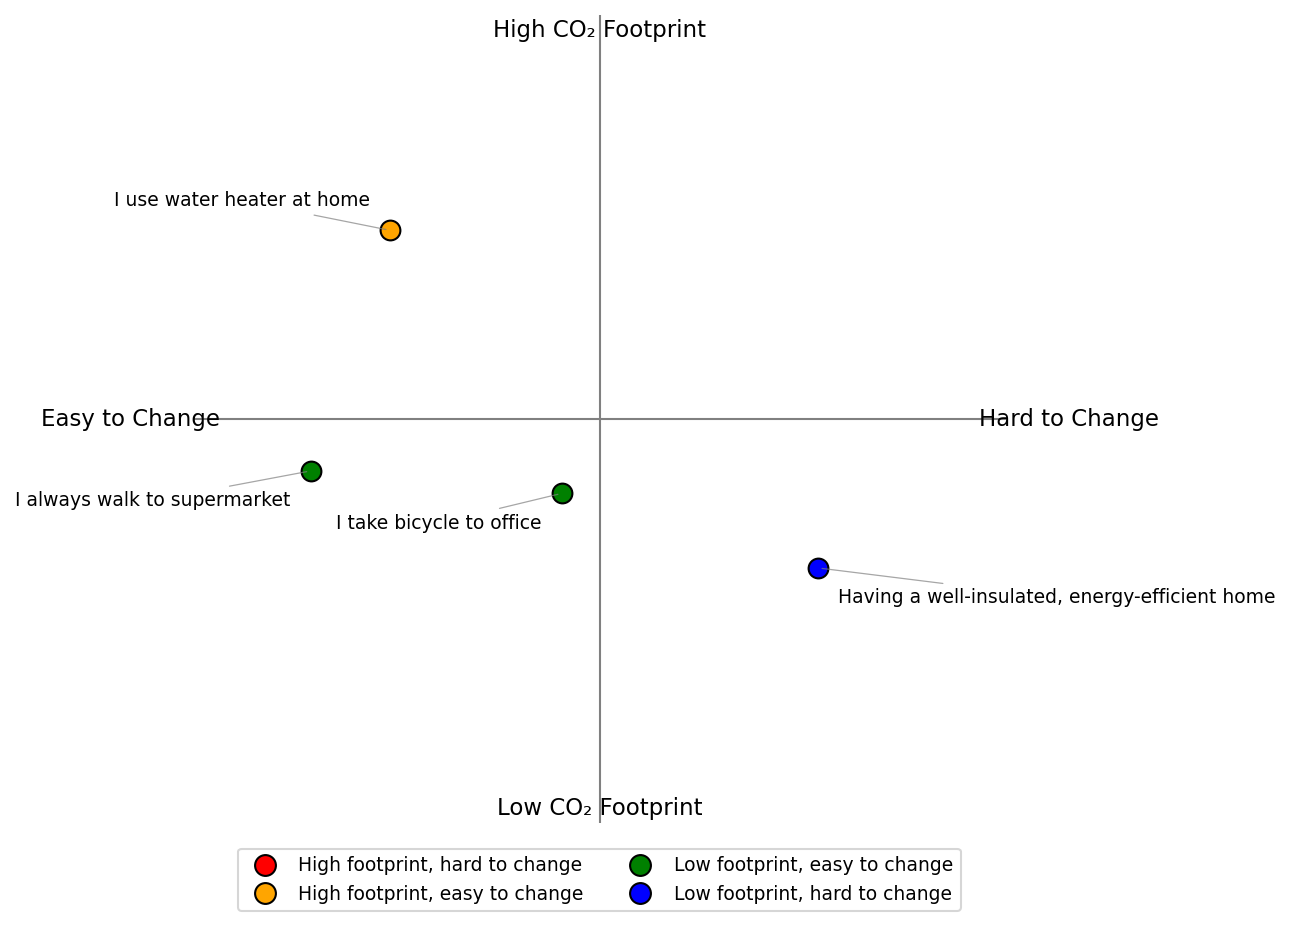

In [ ]:
from IPython.display import Image, display

display(Image("/tmp/climate_compass.png"))


**Conclusion:**

Built an AI agent successfully using Mistral LLM model and LangGraph agent framework that generates the  2x2 quadrant by mapping person's lifestyle choices.